In [3]:
import csv
from typing import Text
from yaml import tokens
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST, EMNIST

from helper import Helper
import random
from utils.text_load import Dictionary
from models.word_model import RNNModel
from models.resnet import ResNet18
from models.lenet import LeNet
from models.edge_case_cnn import Net
from models.resnet9 import ResNet9
from utils.text_load import *
import numpy as np
import copy
from torch.utils.data import Dataset, DataLoader

import os
from torchvision import datasets, transforms
from collections import defaultdict
from torch.utils.data import DataLoader, random_split, TensorDataset
import pickle
from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam
import PIL
import matplotlib.pyplot as plt
import cv2 as cv


def superimpose(background, overlay):
    # added_image = background
    added_image = cv.addWeighted(background,0.3,overlay,0.3,-133)
    return (added_image.reshape(32,32,3))

label_dict = {
    0:'plane',
    1:'car',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

In [8]:
# patched model
# params = torch.load("D:\code\code_xwd\Durable-Federated-Learning-Backdoor\SAVE_MODEL\cifar10 patched attacknum 450\Backdoor_saved_models_update1_noniid_EC0_cifar10_Baseline_EE3801/target_model_epoch_2180.pth")
# poisoned model
# params = torch.load("D:\code\code_xwd\Durable-Federated-Learning-Backdoor\SAVE_MODEL\cifar10 poisoned attacknum 450\Backdoor_saved_models_update1_noniid_EC0_cifar10_Neurotoxin_GradMaskRation0.95_EE3801//target_model_epoch_2210.pth")
# DBA model
params = torch.load("D:\code\code_xwd\Durable-Federated-Learning-Backdoor\SAVE_MODEL\cifar10-DBA-DP-attacknum200\Backdoor_model_cifar10_resnet_maskRatio1.0_Snorm_0.2_checkpoint_model_epoch_2300.pth")
# no attack model
# params = torch.load("D:\code\code_xwd\Durable-Federated-Learning-Backdoor\FL_Backdoor_CV\saved_models\cifar10_resnet_maskRatio1_Snorm_1.0_checkpoint_model_epoch_1800.pth")


file_benign = 'D:\code\code_xwd\dataset\cifar-10-batches-py/test_batch'
file_attack = 'D:\code\code_xwd\dataset\patch_cifar10/test_batch'
file_attack_poison = 'D:\code\code_xwd\dataset\poison_cifar10/test_batch'
file_attack_DBA = 'D:\code\code_xwd\dataset\DBA_cifar10/test_batch'
dict = unpickle(file_benign)
model = ResNet18(10)
model.cuda()

model.load_state_dict(params)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2,
                                                momentum=0.09,
                                                weight_decay=0.4)

fo = open(file_benign, 'rb')
label = pickle.load(fo, encoding='latin1')
fo.close()
labels = label.get("labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_benign = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_benign[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_benign[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_benign)
        sum = sum + EntropySum_benign[k * 10 + i]
print(sum/100/10)
# print(EntropySum_benign)

# 100张 benign + 10次混合其他图片 在poison下信息熵均值为 -0.8485037518674508
# 100张 poison + 10次混合其他图片 在poison下信息熵均值为 -0.7518131062481552

# 100张 benign + 10次混合其他图片 在patch下信息熵均值为 8.130794444084168
# 100张 patch + 10次混合其他图片 在patch下信息熵均值为 7.389559324502945
dict = unpickle(file_attack)
f1 = open(file_attack, 'rb')
label = pickle.load(f1, encoding='latin1')
f1.close()
labels = label.get("labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack)
        sum = sum + EntropySum_attack[k * 10 + i]
print(sum/100/10)

dict = unpickle(file_attack_poison)
f2 = open(file_attack_poison, 'rb')
label = pickle.load(f2, encoding='latin1')
f2.close()
labels = label.get("labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_poison = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_poison[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_poison[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_poison)
        sum = sum + EntropySum_attack_poison[k * 10 + i]
print(sum/100/10)

dict = unpickle(file_attack_DBA)
f2 = open(file_attack_DBA, 'rb')
label = pickle.load(f2, encoding='latin1')
f2.close()
labels = label.get("labels")

gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')

sum = 0

EntropySum_attack_DBA = [0] * 1000
for k in range (0, 100):
    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    # pil_img = PIL.Image.open(f'D:\code\code_xwd\dataset\cifar-10-batches-py\pic\\test\{k}.jpg')
    image_m = np.reshape(dict.get("data")[k], (3, 32, 32))
    r = image_m[0, :, :]
    g = image_m[1, :, :]
    b = image_m[2, :, :]
    img32 = np.array(cv.merge([r, g, b]))
    img32 = cv.cvtColor(np.array(img32), cv.COLOR_RGB2BGR)
    
    for i in range(10):
        image_trigger = np.reshape(dict.get("data")[i+3333], (3, 32, 32))
        r = image_trigger[0, :, :]
        g = image_trigger[1, :, :]
        b = image_trigger[2, :, :]
        image_trigger = np.array(cv.merge([r, g, b]))
        image_trigger = cv.cvtColor(np.array(image_trigger), cv.COLOR_RGB2BGR)
        
        img32Ptrigger = superimpose(np.array(img32), image_trigger) # 需要传入(32, 32, 3)
        img32Ptrigger = PIL.Image.fromarray(img32Ptrigger)
        
        torch_img = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])(img32Ptrigger).cuda()
        normed_img = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])(torch_img)[None]
        output = model(normed_img).cpu().detach()
        # print(output)
        EntropySum_attack_DBA[k * 10 + i] = -np.nansum(output*np.log2(output))
        # EntropySum_attack_DBA[k * 10 + i] = int(output.data.max(1)[1])  # get the index of the max log-probability
        # print(EntropySum_attack_DBA)
        sum = sum + EntropySum_attack_DBA[k * 10 + i]
print(sum/100/10)

d:\Anaconda3\envs\xwdneurotoxin\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
C:\Users\Administrator\AppData\Local\Temp\ipykernel_11556\2193740551.py:60: RuntimeWarning: invalid value encountered in log2
  EntropySum_benign[k * 10 + i] = -np.nansum(output*np.log2(output))


0.9780234389305115


C:\Users\Administrator\AppData\Local\Temp\ipykernel_11556\2193740551.py:108: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack[k * 10 + i] = -np.nansum(output*np.log2(output))


0.8683469647169113


C:\Users\Administrator\AppData\Local\Temp\ipykernel_11556\2193740551.py:150: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack_poison[k * 10 + i] = -np.nansum(output*np.log2(output))


0.961595785677433


C:\Users\Administrator\AppData\Local\Temp\ipykernel_11556\2193740551.py:192: RuntimeWarning: invalid value encountered in log2
  EntropySum_attack_DBA[k * 10 + i] = -np.nansum(output*np.log2(output))


0.9408962698578834


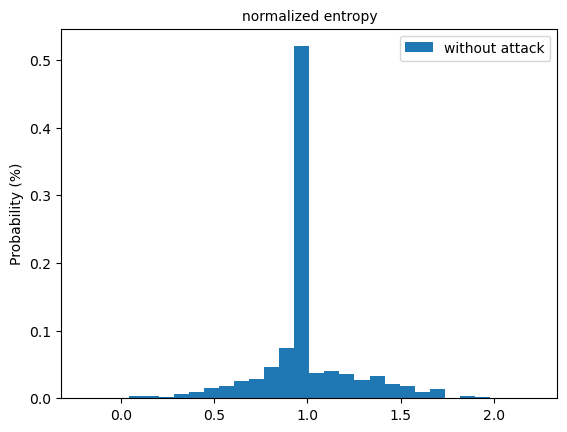

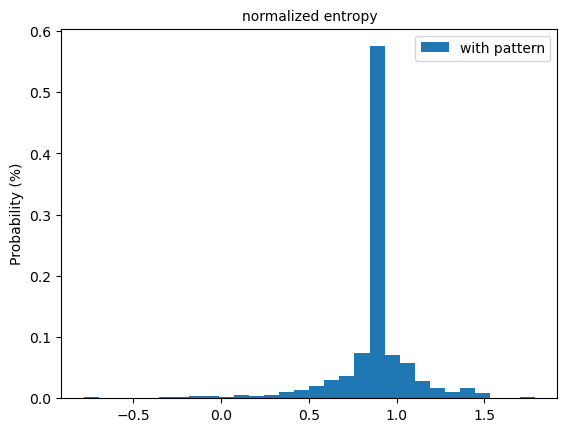

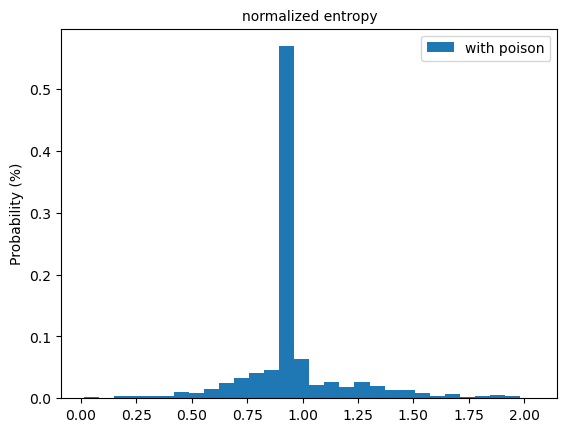

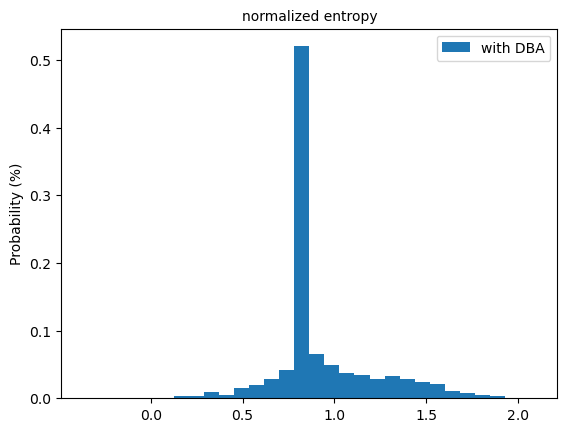

In [9]:
bins = 30
plt.figure(dpi=100)

plt.hist(EntropySum_benign, bins, weights=np.ones(len(EntropySum_benign)) / len(EntropySum_benign), alpha=1, label='without attack')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
plt.figure(dpi=100)
plt.hist(EntropySum_attack, bins, weights=np.ones(len(EntropySum_attack)) / len(EntropySum_attack), alpha=1, label='with pattern')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
plt.figure(dpi=100)
plt.hist(EntropySum_attack_poison, bins, weights=np.ones(len(EntropySum_attack_poison)) / len(EntropySum_attack_poison), alpha=1, label='with poison')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
plt.figure(dpi=100)
plt.hist(EntropySum_attack_DBA, bins, weights=np.ones(len(EntropySum_attack_DBA)) / len(EntropySum_attack_DBA), alpha=1, label='with DBA')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy', fontsize = 10)
plt.tick_params(labelsize=10)
fig1 = plt.gcf()
plt.show()

# org && org+trigger 的熵 对比，poison差别不大，patch趋势差别很大，
# no attack 和 poison 和 patch在benign数据下的熵的对比